In [2]:
import pandas as pd

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(0)

In [3]:
print(torch.cuda.is_available())

False


# Prepare data

In [5]:
df = pd.read_csv('data/Monthly_Average_1950_2009_reservoir.csv')

In [6]:
tensor_x = torch.Tensor(df.values) # transform to torch tensor
dataset = TensorDataset(tensor_x) # create your datset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # create your dataloader

# Define a network

In [7]:
# linear, batch norm, relu block
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

In [8]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=2, im_dim=6, hidden_dim=8):
        super().__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
        )
    def forward(self, noise):
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [9]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)

In [10]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
         nn.Linear(input_dim, output_dim),
         nn.LeakyReLU(0.2, inplace=True)
    )

In [11]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=6, hidden_dim=8):
        super().__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [13]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [14]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

# Train

In [56]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 2
display_step = 500
batch_size = 32

lr = 0.00001
lr = 0.006
device = 'cpu'

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device) 

#gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
#disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
gen_opt = torch.optim.SGD(gen.parameters(), lr=lr)
disc_opt = torch.optim.SGD(disc.parameters(), lr=lr)

In [57]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
    fake__ = []
    real__ = []
    # Dataloader returns the batches
    for real in dataloader:
        cur_batch_size = len(real[0])
        real_ = real[0].to(device)
        # Flatten the batch of real images from the dataset
        #real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real_, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        # Update generator
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        real__.append(real_.cpu().detach().numpy())
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake__.append(gen(fake_noise).cpu().detach().numpy())
        
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            # show_tensor_images(fake)
            # show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

Step 500: Generator loss: 0.7778016046285626, discriminator loss: 0.46189409923553476
Step 1000: Generator loss: 0.8134022765159611, discriminator loss: 0.5551239207386968
Step 1500: Generator loss: 0.8090449287891384, discriminator loss: 0.7006267020702358
Step 2000: Generator loss: 0.8182168577909473, discriminator loss: 0.7322597503662103
Step 2500: Generator loss: 0.8345523921251298, discriminator loss: 0.709226697444916
Step 3000: Generator loss: 0.8192170411348345, discriminator loss: 0.6861659988164897
Step 3500: Generator loss: 0.757417618393897, discriminator loss: 0.6858785830736165
Step 4000: Generator loss: 0.6909255512952805, discriminator loss: 0.6933131592273705
Step 4500: Generator loss: 0.6558252264261252, discriminator loss: 0.6955311344861986


# Check results

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
fake_noise = get_noise(720, z_dim, device=device)
fake = gen(fake_noise).cpu().detach().numpy()
real = df.values
n = real.shape[0]

In [60]:
# mean error (%)
mean_error = (fake.mean(axis=0) - real.mean(axis=0)) / real.mean(axis=0) * 100

# std error (%)
std_error = (fake.std(axis=0) - real.std(axis=0)) / real.std(axis=0) * 100

# Combine
stats_df = pd.DataFrame([mean_error, std_error], 
                        columns=df.columns, 
                        index=['Mean error', 'Std error'])

# Mean absolute percent error
mape_df = stats_df.abs().mean(axis=1)

with pd.option_context('display.float_format', '{:.2f}%'.format, 'display.expand_frame_repr', False):
    print('---Individual watersheds---')
    print(stats_df)
    print('---Summary (MAPE)---')
    print(mape_df)


---Individual watersheds---
            Cannonsville  Pepacton   Neversink   Rondout   Ashokan   Schoharie 
Mean error       -13.13%      4.74%     -17.23%     0.45%   -13.48%      -4.13%
Std error        -13.27%     -8.58%     -12.07%    -5.35%   -17.48%      -7.09%
---Summary (MAPE)---
Mean error    8.86%
Std error    10.64%
dtype: float64


In [61]:
# Calculate empirical CDFs
bins = np.linspace(0, 15, 61)   # Maximum 15 mm for now
binsize = bins[1:] - bins[:-1]

real_hist = np.apply_along_axis(lambda a: np.histogram(a, bins=bins, density=True)[0], 0, real)
real_ecdf = np.cumsum(real_hist, axis=0) * binsize[:, np.newaxis]

fake_hist = np.apply_along_axis(lambda a: np.histogram(a, bins=bins, density=True)[0], 0, fake)
fake_ecdf = np.cumsum(fake_hist, axis=0) * binsize[:, np.newaxis]

# Continuous ranked probability score (CRPS)
crps = np.sum(np.abs((real_ecdf - fake_ecdf) * binsize[:, np.newaxis]), axis=0)

# Kolmogorov-Smirnov Test
ks = np.abs((real_ecdf - fake_ecdf)).max(axis=0)

# DataFame
diststats_df = pd.DataFrame([crps, ks], columns=df.columns, index=['CRPS', 'KS'])

with pd.option_context('display.float_format', '{:.2f}'.format, 'display.expand_frame_repr', False):
    print('---Individual watersheds---')
    print(diststats_df)
    print('---Summary (mean)---')
    print(diststats_df.mean(axis=1))

---Individual watersheds---
      Cannonsville  Pepacton   Neversink   Rondout   Ashokan   Schoharie 
CRPS          0.48       0.16        0.68      0.31      0.54        0.19
KS            0.21       0.07        0.17      0.11      0.12        0.06
---Summary (mean)---
CRPS   0.39
KS     0.12
dtype: float64


In [46]:
from scipy import stats
ks_res = stats.kstest(real[:, 0], fake[:, 0])

print(f'KS = {ks_res.statistic:.3f}, p-value = {ks_res.pvalue:.3g}')

KS = 0.697, p-value = 6.6e-168


In [62]:
# Create dataframes for plotting
real_df = pd.concat([pd.DataFrame(
    {'data': real[:, i], 'type':'real', 'station': i+1}) for i in range(6)])
fake_df = pd.concat([pd.DataFrame(
    {'data': fake[:, i], 'type':'fake', 'station': i+1}) for i in range(6)])

all_df = pd.concat([real_df, fake_df])

<AxesSubplot: xlabel='station', ylabel='data'>

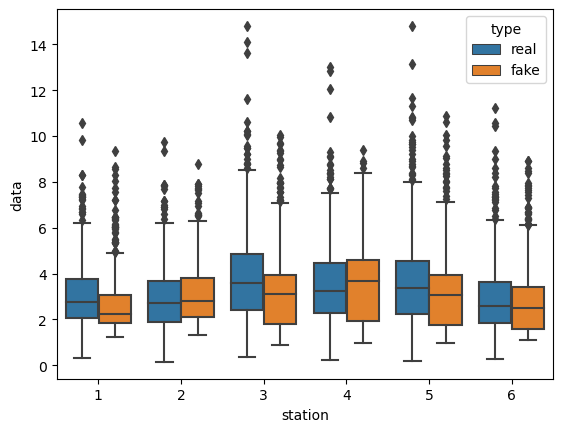

In [63]:
sns.boxplot(data=all_df, x="station", y="data", hue="type")

Text(0.5, 1.0, 'Real')

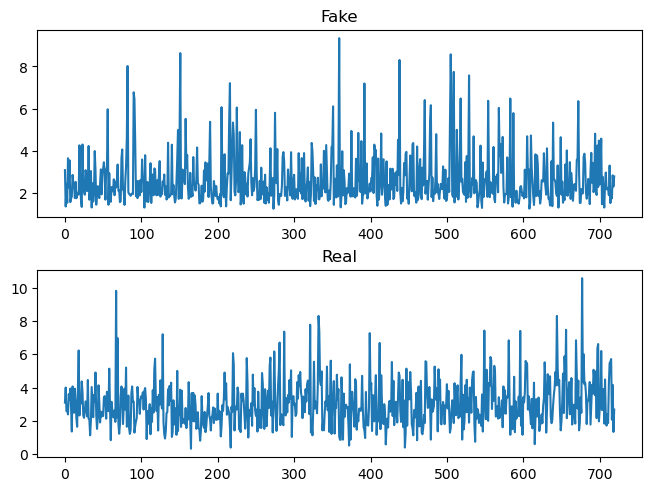

In [64]:
fig, axs = plt.subplots(2, layout='constrained')
axs[0].plot(fake[:, 0])
axs[0].set_title('Fake')
axs[1].plot(real[:, 0])
axs[1].set_title('Real')

### One watershed example

In [66]:
# Calculate empirical CDFs
bins = np.linspace(0, 15, 50)
binsize = bins[1:] - bins[:-1]

real_hist, _ = np.histogram(real[:, 0], bins=bins, density=True)
real_ecdf = np.cumsum(real_hist) * binsize

fake_hist, _ = np.histogram(fake[:, 0], bins=bins, density=True)
fake_ecdf = np.cumsum(fake_hist) * binsize

# Continuous ranked probability score (CRPS)
crps = np.sum(np.abs((real_ecdf - fake_ecdf) * binsize), axis=0)

print(crps)

0.47491496598639604


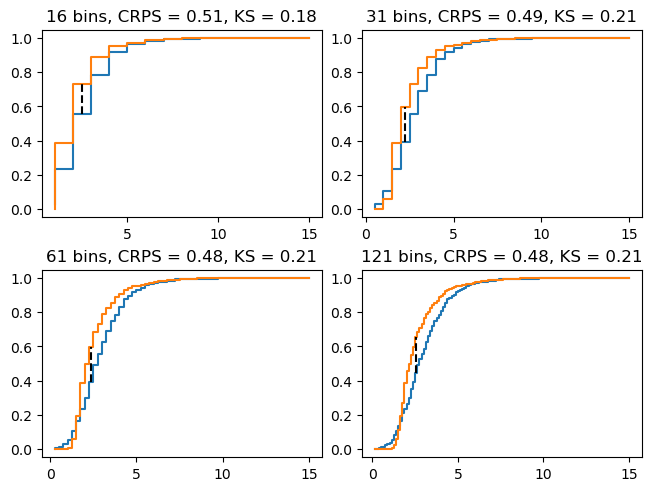

In [67]:
fig, axs = plt.subplots(2, 2, layout='constrained')

for ax, nbin in zip(axs.flat, [16, 31, 61, 121]):
    bins = np.linspace(0, 15, nbin)
    binsize = bins[1:] - bins[:-1]

    real_hist, _ = np.histogram(real[:, 0], bins=bins, density=True)
    real_ecdf = np.cumsum(real_hist) * binsize

    fake_hist, _ = np.histogram(fake[:, 0], bins=bins, density=True)
    fake_ecdf = np.cumsum(fake_hist) * binsize

    # Continuous ranked probability score (CRPS)
    crps = np.sum(np.abs((real_ecdf - fake_ecdf) * binsize), axis=0)
    
    # Kolmogorov-Smirnov Test
    ks = np.abs((real_ecdf - fake_ecdf)).max()
    ks_ind = np.abs((real_ecdf - fake_ecdf)).argmax()
    
    ax.step(bins[1:], real_ecdf)
    ax.step(bins[1:], fake_ecdf)
    ax.vlines(bins[ks_ind:ks_ind+2].mean(), real_ecdf[ks_ind], fake_ecdf[ks_ind], color='k', ls='--')
    
    ax.set_title(f'{nbin} bins, CRPS = {crps:.2f}, KS = {ks:.2f}')


[Text(0, 0.5, 'Cumulative probability')]

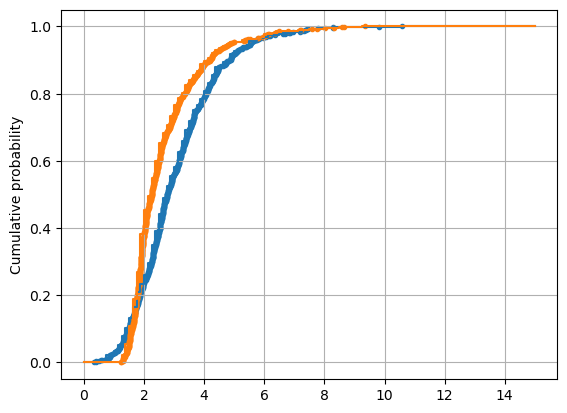

In [68]:
fig, ax = plt.subplots()

ax.scatter(np.sort(real[:, 0]), np.arange(1, n+1)/n, marker='.')
ax.scatter(np.sort(fake[:, 0]), np.arange(1, n+1)/n, marker='.')

ax.step(bins, np.concatenate(([0], real_ecdf)))
ax.step(bins, np.concatenate(([0], fake_ecdf)))

ax.grid()
ax.set(ylabel='Cumulative probability')